# FUTURE MOBILITY CHALLENGE: VEHICLE MOTION PREDICTION
======================================================

### **Submission Date: 09-Feb-2023**
### **Submitted by: Dileep Sathyan & Ambily Treesa Varghese**
### **St. Clair College, Downtown Campus, Windsor, ON, CA**


## Specials thanks to 
### ===== Dr. Umair Durrani - Challenge Mentor & Faculty at St. Clair College
### ===== Prof. John Ulakovich - Event Coordinator & Program Coordinator DAB, St.Clair College 

In [2]:
import math
import numpy as np
import pandas as pd
import datetime as dt
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

from sklearn.datasets import make_regression
from sklearn.metrics import confusion_matrix

## Importing dataset

In [3]:
df = pd.read_csv("Next_Generation_Simulation__NGSIM__Vehicle_Trajectories_and_Supporting_Data.csv")
df.head()

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,...,D_Zone,Int_ID,Section_ID,Direction,Movement,Preceding,Following,Space_Headway,Time_Headway,Location
0,515,2330,1123,1118848075000,30.034,188.062,6451203.729,1873252.549,13.0,6.9,...,NaN,NaN,NaN,NaN,NaN,500,523,119.10,5.11,us-101
1,515,2330,1123,1118848075000,30.034,188.062,6451203.729,1873252.549,13.0,6.9,...,NaN,NaN,NaN,NaN,NaN,500,523,119.10,5.11,us-101
2,2224,6548,1902,1113437421700,41.429,472.901,6042814.264,2133542.012,14.3,6.9,...,NaN,NaN,NaN,NaN,NaN,2208,2211,53.34,2.01,i-80
3,2127,6459,567,1118847624800,19.632,1775.614,6452425.122,1872172.475,13.5,6.9,...,NaN,NaN,NaN,NaN,NaN,2124,2132,48.92,1.30,us-101
4,1033,4827,592,1118848324700,6.202,1701.144,6452347.673,1872258.452,13.5,4.4,...,NaN,NaN,NaN,NaN,NaN,1029,1040,38.81,0.92,us-101


## Data Cleaning & Handling Missing Data

In [4]:
# Drop duplicate records in the dataset
df.drop_duplicates(inplace=True)

In [5]:
df.columns

Index(['Vehicle_ID', 'Frame_ID', 'Total_Frames', 'Global_Time', 'Local_X',
       'Local_Y', 'Global_X', 'Global_Y', 'v_length', 'v_Width', 'v_Class',
       'v_Vel', 'v_Acc', 'Lane_ID', 'O_Zone', 'D_Zone', 'Int_ID', 'Section_ID',
       'Direction', 'Movement', 'Preceding', 'Following', 'Space_Headway',
       'Time_Headway', 'Location'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11146526 entries, 0 to 11850525
Data columns (total 25 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Vehicle_ID     int64  
 1   Frame_ID       int64  
 2   Total_Frames   int64  
 3   Global_Time    int64  
 4   Local_X        float64
 5   Local_Y        float64
 6   Global_X       float64
 7   Global_Y       float64
 8   v_length       float64
 9   v_Width        float64
 10  v_Class        int64  
 11  v_Vel          float64
 12  v_Acc          float64
 13  Lane_ID        int64  
 14  O_Zone         float64
 15  D_Zone         float64
 16  Int_ID         float64
 17  Section_ID     float64
 18  Direction      float64
 19  Movement       float64
 20  Preceding      int64  
 21  Following      int64  
 22  Space_Headway  float64
 23  Time_Headway   float64
 24  Location       object 
dtypes: float64(16), int64(8), object(1)
memory usage: 2.2+ GB


In [7]:
df.isnull().sum()

Vehicle_ID             0
Frame_ID               0
Total_Frames           0
Global_Time            0
Local_X                0
Local_Y                0
Global_X               0
Global_Y               0
v_length               0
v_Width                0
v_Class                0
v_Vel                  0
v_Acc                  0
Lane_ID                0
O_Zone           8665320
D_Zone           8665320
Int_ID           8665320
Section_ID       8665320
Direction        8665320
Movement         8665320
Preceding              0
Following              0
Space_Headway          0
Time_Headway           0
Location               0
dtype: int64

In [8]:
df.drop(columns=['Local_X', 'Global_X', 'Total_Frames', 'O_Zone', 'D_Zone', 
                 'Int_ID', 'Section_ID', 'Direction', 'Movement'], inplace=True)
df.columns

Index(['Vehicle_ID', 'Frame_ID', 'Global_Time', 'Local_Y', 'Global_Y',
       'v_length', 'v_Width', 'v_Class', 'v_Vel', 'v_Acc', 'Lane_ID',
       'Preceding', 'Following', 'Space_Headway', 'Time_Headway', 'Location'],
      dtype='object')

## Fixing the datatypes

In [9]:
# Convert Date to the timestamp
df['Global_Time'] = pd.to_datetime(df['Global_Time'],unit='ms')

# Split Year, Month & Day from the Global_Time
df['Year'] = df.Global_Time.dt.year
df['Month'] = df.Global_Time.dt.month
df['Day'] = df.Global_Time.dt.day

df.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_Y,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway,Location,Year,Month,Day
0,515,2330,2005-06-15 15:07:55.000,188.062,1873252.549,13.0,6.9,2,23.31,2.05,3,500,523,119.10,5.11,us-101,2005,6,15
2,2224,6548,2005-04-14 00:10:21.700,472.901,2133542.012,14.3,6.9,2,26.54,-0.76,4,2208,2211,53.34,2.01,i-80,2005,4,14
3,2127,6459,2005-06-15 15:00:24.800,1775.614,1872172.475,13.5,6.9,2,37.52,11.20,2,2124,2132,48.92,1.30,us-101,2005,6,15
4,1033,4827,2005-06-15 15:12:04.700,1701.144,1872258.452,13.5,4.4,2,41.99,0.10,1,1029,1040,38.81,0.92,us-101,2005,6,15
6,1890,9157,2005-06-15 15:34:32.700,817.521,1872800.663,24.0,8.5,3,45.12,-0.55,5,1882,1897,102.65,2.27,us-101,2005,6,15


## Understanding the Dataset

In [10]:
# Count of Vehicle_ID
df['Vehicle_ID'].nunique()

3233

In [11]:
df['Year'].value_counts()

2005    10272639
1970      873887
Name: Year, dtype: int64

In [12]:
df['Month'].value_counts()

6    5706252
4    4566387
1     873887
Name: Month, dtype: int64

In [13]:
df[(df['Year']== 2005) & (df['Month']== 6)]['Day'].value_counts()

15    4098933
16    1607319
Name: Day, dtype: int64

In [14]:
df[df['Location'] == 'peachtree']['Lane_ID'].unique()

array([   2,    1,    0,   11, 9999,    3, 1061,    4, 1201, 1131, 2081],
      dtype=int64)

In [15]:
df[df['Location'] == 'i-80']['Lane_ID'].unique()

array([4, 5, 6, 3, 2, 1, 7], dtype=int64)

In [16]:
df[df['Location'] == 'lankershim']['Lane_ID'].unique()

array([  1,  12,   3,   2,   4,   0,  11,  31, 101], dtype=int64)

In [17]:
df[df['Location'] == 'us-101']['Lane_ID'].unique()

array([3, 2, 1, 5, 4, 6, 7, 8], dtype=int64)

#### Check how the Location and Lane_ID are connected with each other 

In [18]:
df.Location.value_counts()

i-80          4566387
us-101        4098933
lankershim    1607319
peachtree      873887
Name: Location, dtype: int64

In [19]:
df[['Location', 'Lane_ID']].groupby('Location').max()

,Lane_ID
Location,
i-80,7
lankershim,101
peachtree,9999
us-101,8


## Sort dataframe on Vehicle_ID, Global_Time and Frame_Id fields

In [20]:
df_main_sorted = df.sort_values(by=['Vehicle_ID', 'Global_Time', 'Frame_ID'], 
                                ascending=True).reset_index(drop=True)
df_main_sorted.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_Y,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway,Location,Year,Month,Day
0,1,12,2005-04-13 22:58:56.100,48.213,2133117.662,14.3,6.4,2,12.5,0.0,2,0,0,0.0,0.0,i-80,2005,4,13
1,1,13,2005-04-13 22:58:56.200,49.463,2133118.909,14.3,6.4,2,12.5,0.0,2,0,0,0.0,0.0,i-80,2005,4,13
2,1,14,2005-04-13 22:58:56.300,50.712,2133120.155,14.3,6.4,2,12.5,0.0,2,0,0,0.0,0.0,i-80,2005,4,13
3,1,15,2005-04-13 22:58:56.400,51.963,2133121.402,14.3,6.4,2,12.5,0.0,2,0,0,0.0,0.0,i-80,2005,4,13
4,1,16,2005-04-13 22:58:56.500,53.213,2133122.649,14.3,6.4,2,12.5,0.0,2,0,0,0.0,0.0,i-80,2005,4,13


# Method# 1 :
# Time Series Analysis: Using Auto Regressive Moving Average (ARIMA)

### Subset the data for 1 Vehicle_ID (randomly picked # 515)

In [21]:
df_sub = df_main_sorted[df_main_sorted['Vehicle_ID']==515]
df_sub.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_Y,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway,Location,Year,Month,Day
2216257,515,3016,1970-01-14 11:08:40.200,212.390,1375759.455,14.8,7.2,2,16.97,0.0,3,0,0,0.00,0.00,peachtree,1970,1,14
2216258,515,3017,1970-01-14 11:08:40.300,214.295,1375761.389,14.8,7.2,2,16.97,0.0,0,0,0,0.00,0.00,peachtree,1970,1,14
2216259,515,3018,1970-01-14 11:08:40.400,216.190,1375763.312,14.8,7.2,2,16.97,0.0,0,0,0,0.00,0.00,peachtree,1970,1,14
2216260,515,3019,1970-01-14 11:08:40.500,218.077,1375765.225,14.8,7.2,2,16.97,0.0,0,0,0,0.00,0.00,peachtree,1970,1,14
2216261,515,3020,1970-01-14 11:08:40.600,218.912,1375767.127,14.8,7.2,2,16.97,0.0,2,440,472,388.88,22.92,peachtree,1970,1,14


In [22]:
# Filter it only for the 2005 year.
df_sub1 = df_sub[df_sub['Year'] == 2005]
df_sub1.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_Y,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway,Location,Year,Month,Day
2216963,515,1585,2005-04-13 23:01:33.400,63.521,2133132.973,13.8,6.8,2,24.69,0.0,2,510,0,48.40,1.96,i-80,2005,4,13
2216964,515,1586,2005-04-13 23:01:33.500,66.521,2133135.950,13.8,6.8,2,24.69,0.0,2,510,0,47.85,1.94,i-80,2005,4,13
2216965,515,1587,2005-04-13 23:01:33.600,69.065,2133138.431,13.8,6.8,2,24.69,0.0,2,510,0,47.76,1.93,i-80,2005,4,13
2216966,515,1588,2005-04-13 23:01:33.700,71.065,2133140.416,13.8,6.8,2,24.69,0.0,2,510,0,48.22,1.95,i-80,2005,4,13
2216967,515,1589,2005-04-13 23:01:33.800,74.065,2133143.393,13.8,6.8,2,24.69,0.0,2,510,0,47.67,1.93,i-80,2005,4,13


### Differencing the time field

In [23]:
# First check the time difference in time between the 2 consecutive observations of a Vehicle.

df_sub1['Prev_Global_Time'] = df_sub1['Global_Time'].shift(1)
df_sub1['Time_Lag'] = df_sub1['Global_Time'] - df_sub1['Prev_Global_Time']
df_sub1[['Global_Time', 'Prev_Global_Time', 'Time_Lag']].head(10)

C:\Users\ajuam\AppData\Local\Temp\ipykernel_3080\1856999463.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub1['Prev_Global_Time'] = df_sub1['Global_Time'].shift(1)
C:\Users\ajuam\AppData\Local\Temp\ipykernel_3080\1856999463.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub1['Time_Lag'] = df_sub1['Global_Time'] - df_sub1['Prev_Global_Time']


,Global_Time,Prev_Global_Time,Time_Lag
2216963,2005-04-13 23:01:33.400,NaT,NaT
2216964,2005-04-13 23:01:33.500,2005-04-13 23:01:33.400,0 days 00:00:00.100000
2216965,2005-04-13 23:01:33.600,2005-04-13 23:01:33.500,0 days 00:00:00.100000
2216966,2005-04-13 23:01:33.700,2005-04-13 23:01:33.600,0 days 00:00:00.100000
2216967,2005-04-13 23:01:33.800,2005-04-13 23:01:33.700,0 days 00:00:00.100000
2216968,2005-04-13 23:01:33.900,2005-04-13 23:01:33.800,0 days 00:00:00.100000
2216969,2005-04-13 23:01:34.000,2005-04-13 23:01:33.900,0 days 00:00:00.100000
2216970,2005-04-13 23:01:34.100,2005-04-13 23:01:34.000,0 days 00:00:00.100000
2216971,2005-04-13 23:01:34.200,2005-04-13 23:01:34.100,0 days 00:00:00.100000
2216972,2005-04-13 23:01:34.300,2005-04-13 23:01:34.200,0 days 00:00:00.100000


In [24]:
df_sub1.Time_Lag.value_counts(ascending=False)

0 days 00:00:00.100000     5538
0 days 00:57:53.700000        1
0 days 00:16:07               1
62 days 14:33:54.500000       1
0 days 00:15:25.200000        1
0 days 00:13:46.400000        1
1 days 00:08:39.200000        1
0 days 00:14:41.600000        1
Name: Time_Lag, dtype: int64

## Differencing the Lane_ID & Feature Scaling

In [25]:
df_sub1['Prev_Lane_ID'] = df_sub1['Lane_ID'].shift(1)
df_sub1['In_Same_Lane'] = np.where(df_sub1['Lane_ID'] == df_sub1['Prev_Lane_ID'], 1, 0)
df_sub1[['Global_Time', 'Lane_ID', 'Prev_Lane_ID', 'In_Same_Lane']].head()

C:\Users\ajuam\AppData\Local\Temp\ipykernel_3080\3200089324.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub1['Prev_Lane_ID'] = df_sub1['Lane_ID'].shift(1)
C:\Users\ajuam\AppData\Local\Temp\ipykernel_3080\3200089324.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub1['In_Same_Lane'] = np.where(df_sub1['Lane_ID'] == df_sub1['Prev_Lane_ID'], 1, 0)


,Global_Time,Lane_ID,Prev_Lane_ID,In_Same_Lane
2216963,2005-04-13 23:01:33.400,2,NaN,0
2216964,2005-04-13 23:01:33.500,2,2.0,1
2216965,2005-04-13 23:01:33.600,2,2.0,1
2216966,2005-04-13 23:01:33.700,2,2.0,1
2216967,2005-04-13 23:01:33.800,2,2.0,1


In [26]:
df_sub1.columns

Index(['Vehicle_ID', 'Frame_ID', 'Global_Time', 'Local_Y', 'Global_Y',
       'v_length', 'v_Width', 'v_Class', 'v_Vel', 'v_Acc', 'Lane_ID',
       'Preceding', 'Following', 'Space_Headway', 'Time_Headway', 'Location',
       'Year', 'Month', 'Day', 'Prev_Global_Time', 'Time_Lag', 'Prev_Lane_ID',
       'In_Same_Lane'],
      dtype='object')

In [27]:
# Subsetting the dataframe to remove line change occurences

df_sub2 = df_sub1[df_sub1['In_Same_Lane'] == 1].reset_index(drop=True)
df_sub2.shape

(5531, 23)

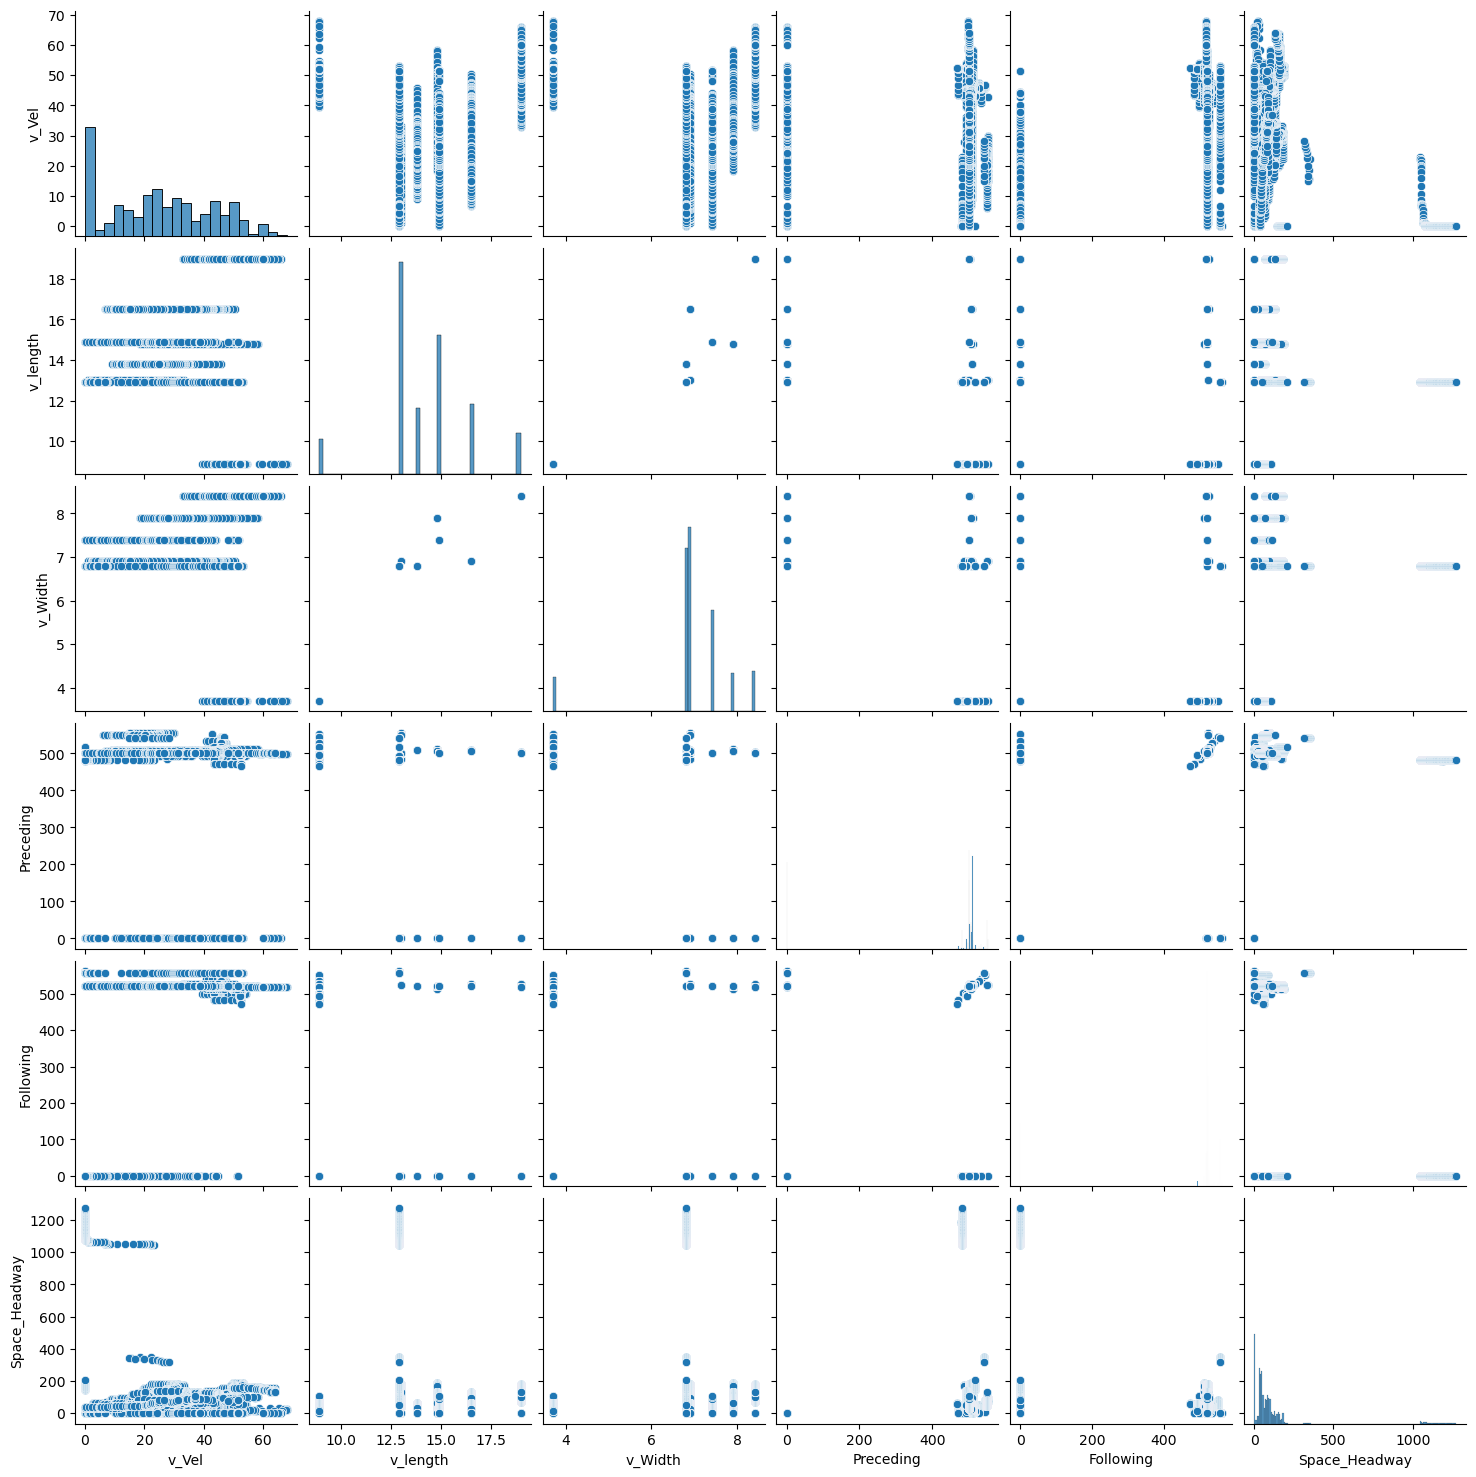

In [28]:
# From the above, Vehicle dimentions / class dont seem to have much corr with the Vel, Hence keeping relevant features.

sns.pairplot(df_sub2[['v_Vel', 'v_length', 'v_Width', 'Preceding', 
                    'Following', 'Space_Headway', 'Location', 'Time_Lag']])

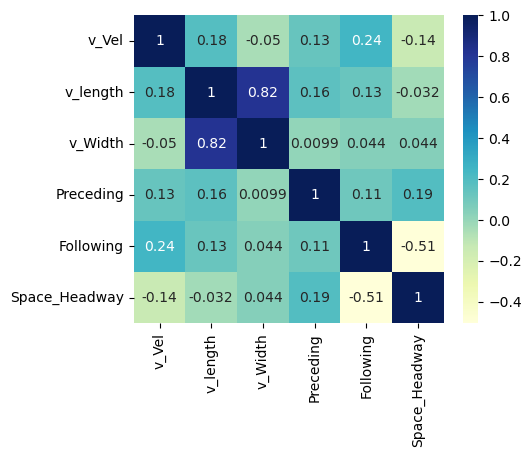

In [29]:
corr = df_sub2[['v_Vel', 'v_length', 'v_Width', 'Preceding', 'Following', 
              'Space_Headway', 'Location', 'Time_Lag']].corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap='YlGnBu')
plt.show()

### Could not find considerable correlation among the variables.
### Hence proceeding with Auto Regressive Moving Average Model

## Apply ARIMA Model

In [30]:
df_sub3 = df_sub2[['v_Vel']].reset_index(drop=True)
df_sub3.head()

,v_Vel
0,24.69
1,24.69
2,24.69
3,24.69
4,24.69


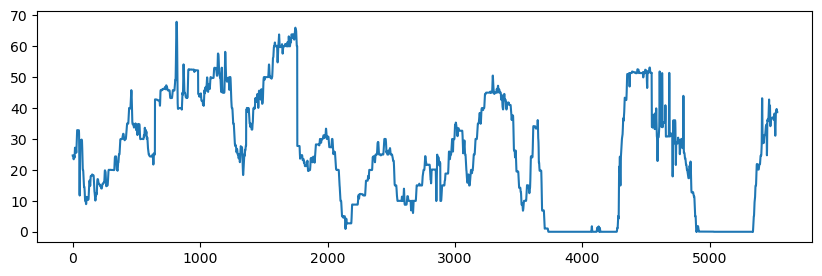

In [31]:
plt.figure(figsize=(10,3))
plt.plot(df_sub3.v_Vel)
plt.show()

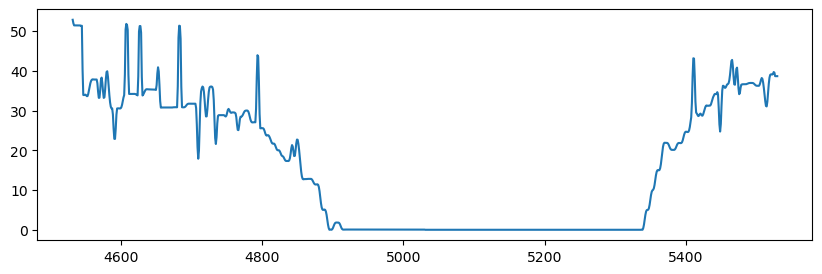

In [32]:
# Take a closer look at the last 300 datapoints of Velocity

plt.figure(figsize=(10,3))
plt.plot(df_sub3.v_Vel.tail(1000))
plt.show()

### Find the Differencing "d" value

In [33]:
df_sub2.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_Y,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,...,Space_Headway,Time_Headway,Location,Year,Month,Day,Prev_Global_Time,Time_Lag,Prev_Lane_ID,In_Same_Lane
0,515,1586,2005-04-13 23:01:33.500,66.521,2133135.950,13.8,6.8,2,24.69,0.00,...,47.85,1.94,i-80,2005,4,13,2005-04-13 23:01:33.400,0 days 00:00:00.100000,2.0,1
1,515,1587,2005-04-13 23:01:33.600,69.065,2133138.431,13.8,6.8,2,24.69,0.00,...,47.76,1.93,i-80,2005,4,13,2005-04-13 23:01:33.500,0 days 00:00:00.100000,2.0,1
2,515,1588,2005-04-13 23:01:33.700,71.065,2133140.416,13.8,6.8,2,24.69,0.00,...,48.22,1.95,i-80,2005,4,13,2005-04-13 23:01:33.600,0 days 00:00:00.100000,2.0,1
3,515,1589,2005-04-13 23:01:33.800,74.065,2133143.393,13.8,6.8,2,24.69,0.00,...,47.67,1.93,i-80,2005,4,13,2005-04-13 23:01:33.700,0 days 00:00:00.100000,2.0,1
4,515,1590,2005-04-13 23:01:33.900,76.372,2133145.650,13.8,6.8,2,24.69,-4.67,...,47.81,1.94,i-80,2005,4,13,2005-04-13 23:01:33.800,0 days 00:00:00.100000,2.0,1


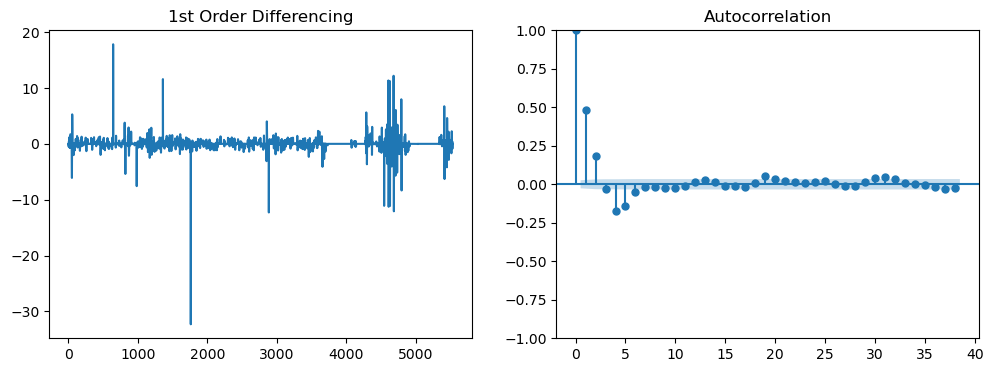

In [34]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(df_sub2.v_Vel.diff())

ax2 = f.add_subplot(122)
plot_acf(df_sub2.v_Vel.diff().dropna(), ax=ax2)
plt.show()

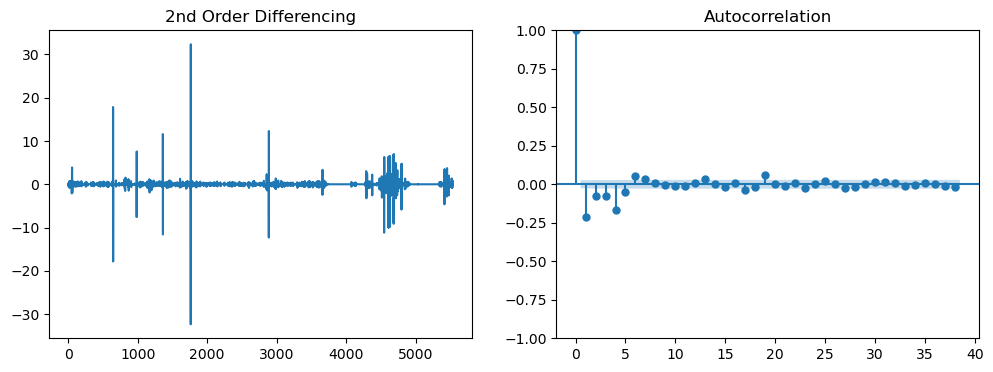

In [35]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax1.set_title('2nd Order Differencing')
ax1.plot(df_sub2.v_Vel.diff().diff())

ax2 = f.add_subplot(122)
plot_acf(df_sub2.v_Vel.diff().diff().dropna(), ax=ax2)
plt.show()

In [36]:
# From the above ACF chart, the 2nd order differencing suggests considering 4 as d but we can reconfirm the same using ADF.

res = adfuller(df_sub2.v_Vel.dropna())
print('p-value: ', res[1])

for i in range(2,8):
    res = adfuller(df_sub2.v_Vel.diff(i).dropna())
    print(f'p-value with diff at {i} degree (d): {res[1]}')


p-value:  0.1305317359678878
p-value with diff at 2 degree (d): 1.2761442329344214e-20
p-value with diff at 3 degree (d): 1.764963401956173e-19
p-value with diff at 4 degree (d): 6.245961269884579e-21
p-value with diff at 5 degree (d): 3.724695629364263e-21
p-value with diff at 6 degree (d): 3.491270862321116e-20
p-value with diff at 7 degree (d): 1.2974294658732756e-20


### Find the order for the AR model: "p" value

C:\Users\ajuam\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


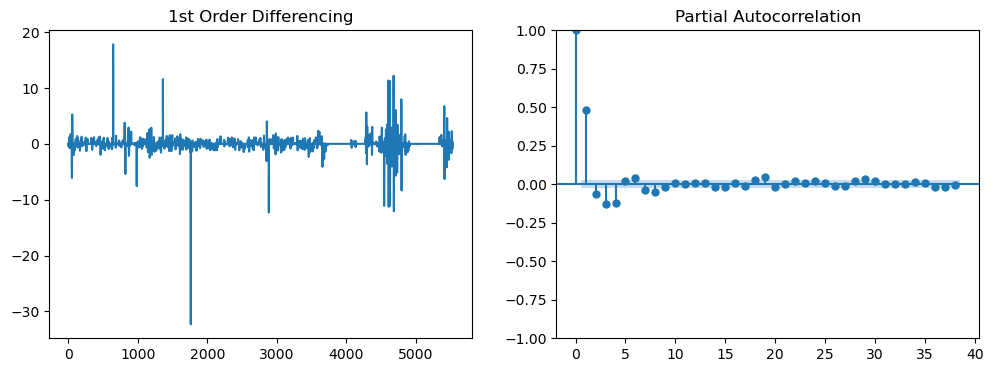

In [37]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(df_sub2.v_Vel.diff())

ax2 = f.add_subplot(122)
plot_pacf(df_sub2.v_Vel.diff().dropna(), ax=ax2)
plt.show()

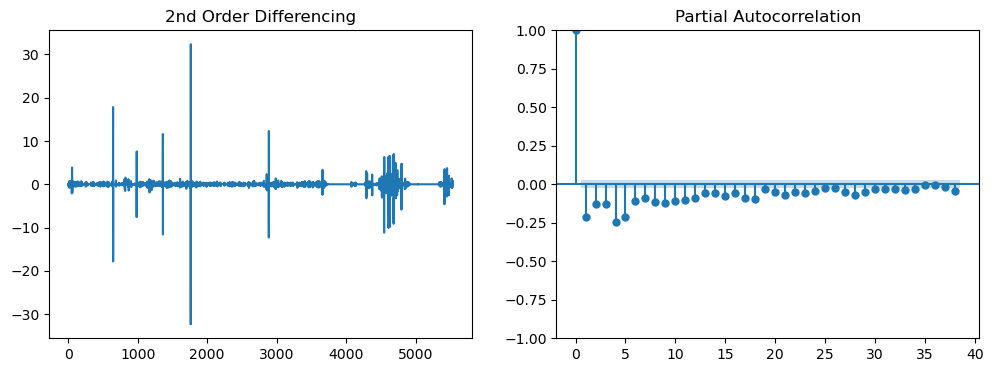

In [38]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax1.set_title('2nd Order Differencing')
ax1.plot(df_sub2.v_Vel.diff().diff())

ax2 = f.add_subplot(122)
plot_pacf(df_sub2.v_Vel.diff().diff().dropna(), ax=ax2)
plt.show()

#### From the 2nd chart the "p" is significant with 2nd degree, hence lets consider p = 2

### ARIMA: Modeling & Fitting

In [39]:
ar_model = ARIMA(df_sub2.v_Vel, order=(4,1,2))
model = ar_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  v_Vel   No. Observations:                 5531
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -6961.094
Date:                Thu, 09 Feb 2023   AIC                          13936.187
Time:                        17:31:30   BIC                          13982.513
Sample:                             0   HQIC                         13952.341
                               - 5531                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5993      0.085      7.010      0.000       0.432       0.767
ar.L2         -0.4365      0.083     -5.274      0.000      -0.599      -0.274
ar.L3          0.1331      0.028      4.816      0.0

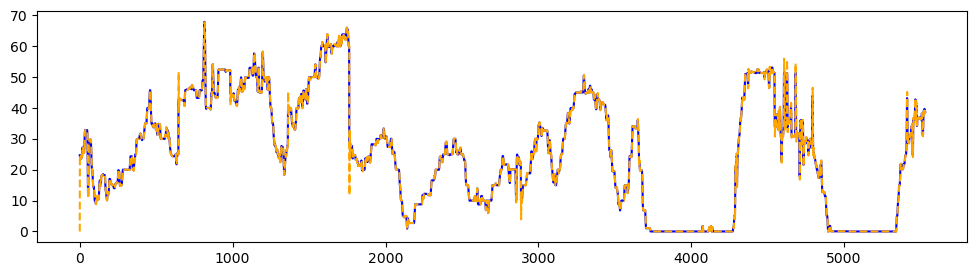

In [40]:
plt.figure(figsize=(12,3))
plt.plot(df_sub2.v_Vel, "b", label = "line 1", linestyle="-")
plt.plot(model.predict(), "orange", label = "line 2", linestyle="--")
plt.show()

#### Check RMSE of ARIMA model

In [41]:
y_actual = df_sub2.v_Vel
y_predicted = model.predict()

mse = mean_squared_error(y_actual, y_predicted)
rmse = math.sqrt(mse)
print("The RMSE between actual and predicted values", rmse)  

The RMSE between actual and predicted values 0.9143080628168452


###### 

In [42]:
df_sub1.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_Y,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,...,Space_Headway,Time_Headway,Location,Year,Month,Day,Prev_Global_Time,Time_Lag,Prev_Lane_ID,In_Same_Lane
2216963,515,1585,2005-04-13 23:01:33.400,63.521,2133132.973,13.8,6.8,2,24.69,0.0,...,48.40,1.96,i-80,2005,4,13,NaT,NaT,NaN,0
2216964,515,1586,2005-04-13 23:01:33.500,66.521,2133135.950,13.8,6.8,2,24.69,0.0,...,47.85,1.94,i-80,2005,4,13,2005-04-13 23:01:33.400,0 days 00:00:00.100000,2.0,1
2216965,515,1587,2005-04-13 23:01:33.600,69.065,2133138.431,13.8,6.8,2,24.69,0.0,...,47.76,1.93,i-80,2005,4,13,2005-04-13 23:01:33.500,0 days 00:00:00.100000,2.0,1
2216966,515,1588,2005-04-13 23:01:33.700,71.065,2133140.416,13.8,6.8,2,24.69,0.0,...,48.22,1.95,i-80,2005,4,13,2005-04-13 23:01:33.600,0 days 00:00:00.100000,2.0,1
2216967,515,1589,2005-04-13 23:01:33.800,74.065,2133143.393,13.8,6.8,2,24.69,0.0,...,47.67,1.93,i-80,2005,4,13,2005-04-13 23:01:33.700,0 days 00:00:00.100000,2.0,1


In [43]:
df_sub2.columns

Index(['Vehicle_ID', 'Frame_ID', 'Global_Time', 'Local_Y', 'Global_Y',
       'v_length', 'v_Width', 'v_Class', 'v_Vel', 'v_Acc', 'Lane_ID',
       'Preceding', 'Following', 'Space_Headway', 'Time_Headway', 'Location',
       'Year', 'Month', 'Day', 'Prev_Global_Time', 'Time_Lag', 'Prev_Lane_ID',
       'In_Same_Lane'],
      dtype='object')

In [44]:
df_sub2.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_Y,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,...,Space_Headway,Time_Headway,Location,Year,Month,Day,Prev_Global_Time,Time_Lag,Prev_Lane_ID,In_Same_Lane
0,515,1586,2005-04-13 23:01:33.500,66.521,2133135.950,13.8,6.8,2,24.69,0.00,...,47.85,1.94,i-80,2005,4,13,2005-04-13 23:01:33.400,0 days 00:00:00.100000,2.0,1
1,515,1587,2005-04-13 23:01:33.600,69.065,2133138.431,13.8,6.8,2,24.69,0.00,...,47.76,1.93,i-80,2005,4,13,2005-04-13 23:01:33.500,0 days 00:00:00.100000,2.0,1
2,515,1588,2005-04-13 23:01:33.700,71.065,2133140.416,13.8,6.8,2,24.69,0.00,...,48.22,1.95,i-80,2005,4,13,2005-04-13 23:01:33.600,0 days 00:00:00.100000,2.0,1
3,515,1589,2005-04-13 23:01:33.800,74.065,2133143.393,13.8,6.8,2,24.69,0.00,...,47.67,1.93,i-80,2005,4,13,2005-04-13 23:01:33.700,0 days 00:00:00.100000,2.0,1
4,515,1590,2005-04-13 23:01:33.900,76.372,2133145.650,13.8,6.8,2,24.69,-4.67,...,47.81,1.94,i-80,2005,4,13,2005-04-13 23:01:33.800,0 days 00:00:00.100000,2.0,1


## Applying Laws of Motion to find the Acceleration and Location from Velocity

In [48]:
# Find Time_Delta

df_sub_main = df_sub2.copy()

df_sub_main['Prev_Global_Time'] = df_sub_main['Global_Time'].shift(1)
df_sub_main['Time_Delta_Sec'] = (df_sub_main['Global_Time'] - df_sub_main['Prev_Global_Time']) / pd.Timedelta(seconds=1)

df_sub_main[['Global_Time', 'Prev_Global_Time', 'Time_Delta_Sec']].head()

,Global_Time,Prev_Global_Time,Time_Delta_Sec
0,2005-04-13 23:01:33.500,NaT,NaN
1,2005-04-13 23:01:33.600,2005-04-13 23:01:33.500,0.1
2,2005-04-13 23:01:33.700,2005-04-13 23:01:33.600,0.1
3,2005-04-13 23:01:33.800,2005-04-13 23:01:33.700,0.1
4,2005-04-13 23:01:33.900,2005-04-13 23:01:33.800,0.1


In [49]:
# Pred_Velocity Delta

df_sub_main['v_Vel_pred'] = y_predicted.values
df_sub_main['v_Vel_pred'] = df_sub_main['v_Vel_pred'].round(decimals = 3)


df_sub_main['v_Vel_Pred_Previous'] = df_sub_main['v_Vel_pred'].shift(1)
df_sub_main['Pred_Velocity_Delta'] = (df_sub_main['v_Vel_pred'] - df_sub_main['v_Vel_Pred_Previous'])

In [54]:
df_sub_main['v_Acc_Pred'] = df_sub_main['Pred_Velocity_Delta'] / df_sub_main['Time_Delta_Sec']
df_sub_main[['v_Acc', 'v_Acc_Pred']].head()

,v_Acc,v_Acc_Pred
0,0.00,NaN
1,0.00,246.9
2,0.00,0.0
3,0.00,0.0
4,-4.67,0.0


In [55]:
df_sub_main[['Global_Time', 'v_Vel_pred', 'v_Acc_Pred']].head()

,Global_Time,v_Vel_pred,v_Acc_Pred
0,2005-04-13 23:01:33.500,0.00,NaN
1,2005-04-13 23:01:33.600,24.69,246.9
2,2005-04-13 23:01:33.700,24.69,0.0
3,2005-04-13 23:01:33.800,24.69,0.0
4,2005-04-13 23:01:33.900,24.69,0.0


# Method# 2 :
# Linear Regression Models

In [145]:
df_main_sorted.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_Y,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway,Location,Year,Month,Day
0,1,12,2005-04-13 22:58:56.100,48.213,2133117.662,14.3,6.4,2,12.5,0.0,2,0,0,0.0,0.0,i-80,2005,4,13
1,1,13,2005-04-13 22:58:56.200,49.463,2133118.909,14.3,6.4,2,12.5,0.0,2,0,0,0.0,0.0,i-80,2005,4,13
2,1,14,2005-04-13 22:58:56.300,50.712,2133120.155,14.3,6.4,2,12.5,0.0,2,0,0,0.0,0.0,i-80,2005,4,13
3,1,15,2005-04-13 22:58:56.400,51.963,2133121.402,14.3,6.4,2,12.5,0.0,2,0,0,0.0,0.0,i-80,2005,4,13
4,1,16,2005-04-13 22:58:56.500,53.213,2133122.649,14.3,6.4,2,12.5,0.0,2,0,0,0.0,0.0,i-80,2005,4,13


### Subset the relevant deatures for modelling

In [149]:
df_main = df_main_sorted.copy()
df_main['Prev_Lane_ID'] = df_main['Lane_ID'].shift(1)
df_main['In_Same_Lane'] = np.where(df_main['Lane_ID'] == df_main['Prev_Lane_ID'], 1, 0)
df_main[['Global_Time', 'Lane_ID', 'Prev_Lane_ID', 'In_Same_Lane']].head()

,Global_Time,Lane_ID,Prev_Lane_ID,In_Same_Lane
0,2005-04-13 22:58:56.100,2,NaN,0
1,2005-04-13 22:58:56.200,2,2.0,1
2,2005-04-13 22:58:56.300,2,2.0,1
3,2005-04-13 22:58:56.400,2,2.0,1
4,2005-04-13 22:58:56.500,2,2.0,1


In [150]:
# Encode the Location field

labelencoder = LabelEncoder()

df_main['Location_Code'] = labelencoder.fit_transform(df_main['Location'])
df_main.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_Y,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,...,Following,Space_Headway,Time_Headway,Location,Year,Month,Day,Prev_Lane_ID,In_Same_Lane,Location_Code
0,1,12,2005-04-13 22:58:56.100,48.213,2133117.662,14.3,6.4,2,12.5,0.0,...,0,0.0,0.0,i-80,2005,4,13,NaN,0,0
1,1,13,2005-04-13 22:58:56.200,49.463,2133118.909,14.3,6.4,2,12.5,0.0,...,0,0.0,0.0,i-80,2005,4,13,2.0,1,0
2,1,14,2005-04-13 22:58:56.300,50.712,2133120.155,14.3,6.4,2,12.5,0.0,...,0,0.0,0.0,i-80,2005,4,13,2.0,1,0
3,1,15,2005-04-13 22:58:56.400,51.963,2133121.402,14.3,6.4,2,12.5,0.0,...,0,0.0,0.0,i-80,2005,4,13,2.0,1,0
4,1,16,2005-04-13 22:58:56.500,53.213,2133122.649,14.3,6.4,2,12.5,0.0,...,0,0.0,0.0,i-80,2005,4,13,2.0,1,0


In [151]:
df_main.columns

Index(['Vehicle_ID', 'Frame_ID', 'Global_Time', 'Local_Y', 'Global_Y',
       'v_length', 'v_Width', 'v_Class', 'v_Vel', 'v_Acc', 'Lane_ID',
       'Preceding', 'Following', 'Space_Headway', 'Time_Headway', 'Location',
       'Year', 'Month', 'Day', 'Prev_Lane_ID', 'In_Same_Lane',
       'Location_Code'],
      dtype='object')

In [152]:
features = ['Vehicle_ID', 'Local_Y', 'v_length', 'v_Width', 'v_Class',
            'Preceding', 'Following', 'Space_Headway', 'Location_Code',
            'In_Same_Lane', 'v_Vel']

df_main = df_main[features]
df_main.head()

,Vehicle_ID,Local_Y,v_length,v_Width,v_Class,Preceding,Following,Space_Headway,Location_Code,In_Same_Lane,v_Vel
0,1,48.213,14.3,6.4,2,0,0,0.0,0,0,12.5
1,1,49.463,14.3,6.4,2,0,0,0.0,0,1,12.5
2,1,50.712,14.3,6.4,2,0,0,0.0,0,1,12.5
3,1,51.963,14.3,6.4,2,0,0,0.0,0,1,12.5
4,1,53.213,14.3,6.4,2,0,0,0.0,0,1,12.5


In [153]:
df_main.isnull().sum()

Vehicle_ID       0
Local_Y          0
v_length         0
v_Width          0
v_Class          0
Preceding        0
Following        0
Space_Headway    0
Location_Code    0
In_Same_Lane     0
v_Vel            0
dtype: int64

### Custom Train test split

In [154]:
# How many Vehicles are there in the dataset in total?
df_main.Vehicle_ID.nunique()

3233

In [155]:
# Get a list of all the Vehicle_ID 
tot_veh_ids = df_main.Vehicle_ID.unique()
tot_veh_ids

array([   1,    2,    3, ..., 3364, 3365, 3366], dtype=int64)

In [156]:
round(3233*.3,0)

970.0

In [157]:
3233-970

2263

In [158]:
train_veh_ids = tot_veh_ids[:2263]
train_veh_ids.shape

(2263,)

In [159]:
train_veh_ids

array([   1,    2,    3, ..., 2261, 2262, 2263], dtype=int64)

In [160]:
df_train = df_main[df_main['Vehicle_ID'].isin(train_veh_ids)]
df_train.head()

,Vehicle_ID,Local_Y,v_length,v_Width,v_Class,Preceding,Following,Space_Headway,Location_Code,In_Same_Lane,v_Vel
0,1,48.213,14.3,6.4,2,0,0,0.0,0,0,12.5
1,1,49.463,14.3,6.4,2,0,0,0.0,0,1,12.5
2,1,50.712,14.3,6.4,2,0,0,0.0,0,1,12.5
3,1,51.963,14.3,6.4,2,0,0,0.0,0,1,12.5
4,1,53.213,14.3,6.4,2,0,0,0.0,0,1,12.5


In [161]:
df_train.Vehicle_ID.nunique()

2263

In [162]:
# df_test = df_main[~df_train].dropna()

df_test = df_main[~df_main.isin(df_train)].dropna()
df_test.head()

,Vehicle_ID,Local_Y,v_length,v_Width,v_Class,Preceding,Following,Space_Headway,Location_Code,In_Same_Lane,v_Vel
9587177,2264.0,22.733,14.8,6.4,2.0,2313.0,0.0,161.49,0.0,0.0,50.95
9587178,2264.0,27.832,14.8,6.4,2.0,2313.0,0.0,161.94,0.0,1.0,50.95
9587179,2264.0,32.932,14.8,6.4,2.0,2313.0,0.0,162.39,0.0,1.0,50.95
9587180,2264.0,38.032,14.8,6.4,2.0,2313.0,0.0,162.84,0.0,1.0,50.95
9587181,2264.0,43.132,14.8,6.4,2.0,2313.0,0.0,163.29,0.0,1.0,50.95


In [163]:
df_test.Vehicle_ID.nunique()

970

In [164]:
df_main.columns

Index(['Vehicle_ID', 'Local_Y', 'v_length', 'v_Width', 'v_Class', 'Preceding',
       'Following', 'Space_Headway', 'Location_Code', 'In_Same_Lane', 'v_Vel'],
      dtype='object')

In [165]:
feats = ['Vehicle_ID', 'Local_Y', 'v_length', 'v_Width', 'v_Class', 'Preceding',
       'Following', 'Space_Headway', 'Location_Code', 'In_Same_Lane']

X_train = df_train[feats]
y_train = df_train['v_Vel']

In [166]:
X_test = df_test[feats]
y_test = df_test['v_Vel']

In [167]:
X_test.Vehicle_ID.nunique()

970

In [168]:
y_train.head()

0    12.5
1    12.5
2    12.5
3    12.5
4    12.5
Name: v_Vel, dtype: float64

In [169]:
y_test.head()

9587177    50.95
9587178    50.95
9587179    50.95
9587180    50.95
9587181    50.95
Name: v_Vel, dtype: float64

### Model Fitting and Training

## OLS Model

In [170]:
# Create a model and fit it to get the results
model1 = sm.OLS(y_train, X_train)
results1 = model1.fit()

# Print the results
print(results1.summary())

print(f'R-squared value :{results1.rsquared}')
print(f'Adjusted R-squared value :{results1.rsquared_adj}')
print(f'Coefficients :{results1.params}')

                                 OLS Regression Results                                
Dep. Variable:                  v_Vel   R-squared (uncentered):                   0.748
Model:                            OLS   Adj. R-squared (uncentered):              0.748
Method:                 Least Squares   F-statistic:                          2.841e+06
Date:                Thu, 09 Feb 2023   Prob (F-statistic):                        0.00
Time:                        16:29:08   Log-Likelihood:                     -3.8986e+07
No. Observations:             9587177   AIC:                                  7.797e+07
Df Residuals:                 9587167   BIC:                                  7.797e+07
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

## Linear Regression Model

In [171]:
model = LinearRegression()
model.fit(X_train, y_train)
print('Accuracy is: ', model.score(X_test, y_test)*100)

# Cross validation
score = cross_val_score(model, X_train, y_train, cv=5)
print('Cross Validation Score: ', np.mean(score)*100)

Accuracy is:  32.376537668539285
Cross Validation Score:  21.07147044456847


## RandomForest Regressor Model

In [ ]:
rf_regr = RandomForestRegressor(n_estimators=10, random_state=42)
rf_regr.fit(X_train, y_train)
res = rf_regr.predict(X_test)

In [ ]:
res.score()